# Graph ConvNet

Neural network based on the paper: `Joshi, Laurent, and Bresson, ‘An Efficient Graph Convolutional Network Technique for the Travelling Salesman Problem’.`

Open questions:
* Difference between Linear and Embedding layer.
* Does it make a difference that no two Linear layers were used for the edge layer?
* Why are the biases disabled for eq 2 and eq 3 - in the paper they are present?
* How does Batch Normalisation work?
* How are class weights calculated
* log_softmax and NLLLoss vs CrossEntropy (CrossEntropy calculation meaning)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from utils.load_data import Data, VRPDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform

## Model Inputs

| Variable | Meaning | Dimensions |
| -------- | ------- | ---------- |
| batch_edges | Adj matrix special connections* | B x num_nodes x num_nodes
| batch_edges_values | Distance Matrix | B x num_nodes x num_nodes
| batch_edges_target | Target adj matrix | B x num_nodes x num_nodes
| batch_nodes | Ones vector | B x num_nodes
| batch_nodes_coord | Coordinates | B x num_nodes x 2
| *batch_nodes_target* | Value represents ordering in tour | B x num_nodes


*special connections:
* 1 - k-nearest neighbour
* 2 - self connections
* 0 - otherwise

In [2]:
train, test = Data.load("vrp_11")

In [3]:
train_dataset, test_dataset = VRPDataset(train), VRPDataset(test)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Visualise an instance

In [5]:
def first(tensor): return tensor[0]

In [6]:
batch_features, batch_targets = next(iter(train_dataloader))
coords = first(batch_features[0]).cpu().numpy()
target = first(batch_targets).cpu().numpy()

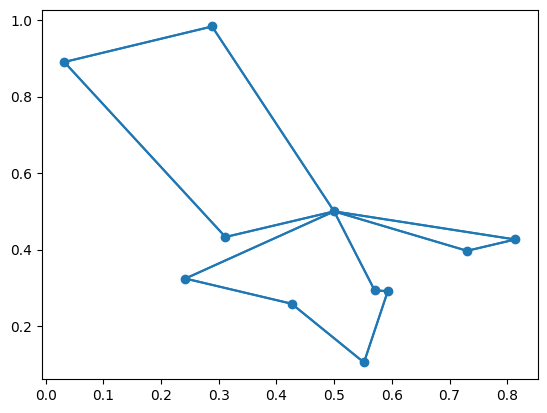

In [7]:
fig, ax = plt.subplots()

ax.scatter(coords[:, 0], coords[:, 1])

for i, row in enumerate(target):
    args = np.argwhere(row>0).flatten()
    x_i = coords[i]
    
    for x_j in coords[args]:
        ax.plot([x_i[0], x_j[0]], [x_i[1], x_j[1]], c='tab:blue')

plt.show()

## Compute class weights

Due to the class imbalance, we need to calculate the class weights.

In [8]:
targets = np.array([target_edges.cpu().numpy() for _, target_edges in train_dataset])

In [9]:
class_labels = targets.flatten()

edge_class_weights = compute_class_weight('balanced',
                                          classes=np.unique(class_labels),
                                          y=class_labels)
edge_class_weights = torch.tensor(edge_class_weights, dtype=torch.float)

## The Model

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device", device)

Device cpu


In [11]:
# == NORMALISATION LAYERS ==
# The normalisation layers are required because the tensors need to
# be transposed for batch normalisation

class EdgeNorm(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.batch_norm = nn.BatchNorm2d(hidden_dim, track_running_stats = False)
    
    def forward(self, e):
        """
        Args:
            e: Edge features (batch x num_nodes x num_nodes x hidden_dim)
        """
        # transpose because batch norm works on the second dim
        e_trans = e.transpose(1, 3).contiguous() # B x hidden_dim x num_nodes x num_nodes
        e_trans_batch_norm = self.batch_norm(e_trans)
        e_batch_norm = e_trans_batch_norm.transpose(1, 3).contiguous() # B x num_nodes x num_nodes x hidden_dim
        
        return e_batch_norm

class NodeNorm(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(hidden_dim, track_running_stats = False)
    
    def forward(self, x):
        """
        Args:
            x: Node features (batch x num_nodes x hidden_dim)
        """
        # transpose because batch norm works on the second dim
        x_trans = x.transpose(1, 2).contiguous() # B x hidden_dim x num_nodes
        x_trans_batch_norm = self.batch_norm(x_trans)
        x_batch_norm = x_trans_batch_norm.transpose(1, 2).contiguous() # B x num_nodes x hidden_dim
        
        return x_batch_norm


class EdgeFeatureLayer(nn.Module):
    """
    W_3 e_ij + W_4 (x_i + x_j) <-- currently the case, but should be: W_3 e_ij + W_4 x_i + W_5 x_j
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W_3 = nn.Linear(hidden_dim, hidden_dim)
        # TODO: Why are not two Linear layers used W_4 and W_5 - does it make a difference?
        self.W_4 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x, e):
        """
        Args:
            x: Node features (batch x num_nodes x hidden_dim)
            e: Edge features (batch x num_nodes x num_nodes x hidden_dim)
        """
        Ue = self.W_3(e)
        Vx = self.W_4(x)
        
        # this enables us to make use of broadcasting to get a B x num_nodes x num_nodes x hidden_dim tensor
        Vx_cols = Vx.unsqueeze(1) # B x num_nodes x hidden_dim => B x 1 x num_nodes x hidden_dim
        Vx_rows = Vx.unsqueeze(2) # B x num_nodes x hidden_dim => B x num_nodes x 1 x hidden_dim
        
        e_new = Ue + Vx_rows + Vx_cols
        
        return e_new
    
class NodeFeatureLayer(nn.Module):
    """
    W_1 x_i + ( sum_j( n_ij * W_2 x_j ) )
    
    where: n_ij = gate_ij / sum_j ( gate_ij + e )
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W_1 = nn.Linear(hidden_dim, hidden_dim)
        self.W_2 = nn.Linear(hidden_dim, hidden_dim)
        self.epsilon = 1e-20
        
    def forward(self, x, edge_gate):
        """
        Args:
            x: Node features (batch x num_nodes x hidden_dim)
            edge_gate: Edge gate run through a sigmoid (batch x num_nodes x num_nodes x hidden_dim)
        """
        W_1_x = self.W_1(x)
        W_2_x = self.W_2(x) # B x num_nodes x hidden_dim

        W_2_x_unsq = W_2_x.unsqueeze(1) # B x num_nodes x hidden_dim ==> B x 1 x num_nodes x hidden_dim
        gate_W2x = edge_gate * W_2_x_unsq
        
        x_new = W_1_x + torch.sum(gate_W2x, dim=2) / (self.epsilon + torch.sum(edge_gate, dim=2)) # B x num_nodes x hidden_dim
        
        return x_new

# == GRAPH LAYER ==

class GraphLayer(nn.Module):
    """
    Graph layer for x_i and e_ij
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.node_feat = NodeFeatureLayer(hidden_dim)
        self.node_norm = NodeNorm(hidden_dim)
        self.edge_feat = EdgeFeatureLayer(hidden_dim)
        self.edge_norm = EdgeNorm(hidden_dim)
        
    def forward(self, x, e):
        """
        Args:
            x: Node features (batch x node_num x hidden_dim)
            e: Edge features (batch x num_nodes x num_nodes x hidden_dim)
        Return:
            x: Aggrgated node features (batch x node_num x hidden_dim)
            e: Aggragated edge features (batch x num_nodes x num_nodes x hidden_dim)
        """
        # edges
        e_feat = self.edge_feat(x, e)
        
        # edge gates
        e_gates = F.sigmoid(e_feat)
        
        # nodes
        x_feat = self.node_feat(x, e_gates)
        
        # normalisation
        x_norm = self.node_norm(x_feat)
        e_norm = self.edge_norm(e_feat)
        
        # activation
        x_act = F.relu(x_norm)
        e_act = F.relu(e_norm)
        
        # combine
        x_new = x + x_act
        e_new = e + e_act
        
        return x_new, e_new
        
# == MLP (Edge predictions) ==

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers):
        super().__init__()
        
        self.layers = nn.Sequential()
        
        for i in range(hidden_layers - 1):
            i += 1
            self.layers.add_module(f'lin{i}', nn.Linear(in_dim, in_dim))
            self.layers.add_module(f'relu{i}', nn.ReLU())
            
        self.layers.add_module('final', nn.Linear(in_dim, out_dim))
        
    def forward(self, e):
        """
        Args:
            e: Edge features (batch x num_nodes x num_nodes x hidden_dim)
        Returns:
            y: Edge predictions (batch x num_nodes x num_nodes x out_dim)
        """
        
        return self.layers(e)

    
# == MAIN NETWORK ==

class GraphNet(nn.Module):
    def __init__(self):
        super().__init__()
        # configs
        self.hidden_dim = 8
        self.num_gcn_layers = 2
        self.num_mlp_layers = 2
        
        # embeddings
        # TODO: Why is bias turned off when in the paper they don't mention anything?
        self.node_coord_embedding = nn.Linear(2, self.hidden_dim, bias=False)
        self.distance_embedding = nn.Linear(1, self.hidden_dim // 2, bias=False)
        # TODO: Don't understand the use of the Embedding layer
        self.edge_type_embedding = nn.Embedding(3, self.hidden_dim // 2) # 3 for the special cases 0, 1, 2 (more memory efficient)
        
        # GCN layers
        self.gcn_layers = nn.ModuleList([
            GraphLayer(hidden_dim=self.hidden_dim) for _ in range(self.num_gcn_layers)
        ])
        
        # edge prediction MLP
        self.mlp_edges = MLP(in_dim=self.hidden_dim, out_dim=2, hidden_layers=self.num_mlp_layers)
        
    def forward(self, node_coords, distance_matrix, edge_types):
        """
        Args:
            node_coords: Coordinates for each node (batch x num_nodes x num_nodes)
            distance_matrix: Distance matrix between nodes (batch x num_nodes x num_nodes)
            edge_types: Edge types to help learn faster (batch x num_nodes x num_nodes)
        """
        # eq 2
        x = self.node_coord_embedding(node_coords) # B x num_nodes x hidden_dim
        
        # eq 3
        dist_unsqueezed = distance_matrix.unsqueeze(3) # B x num_nodes x num_nodes x 1
        e_dist = self.distance_embedding(dist_unsqueezed) # B x num_nodes x num_nodes x hidden_dim // 2
        e_types = self.edge_type_embedding(edge_types) # B x num_nodes x num_nodes x hidden_dim // 2
        e = torch.cat((e_dist, e_types), dim=3) # B x num_nodes x num_nodes x hidden_dim
        
        # eq 4 and 5
        for gcn_layer in self.gcn_layers:
            _x, e = gcn_layer(x, e) # B x num_nodes x hidden_dim, B x num_nodes x num_nodes x hidden_dim
            
        # eq 6
        y_edge_preds = self.mlp_edges(e) # B x num_nodes x num_nodes x 2
        
        return y_edge_preds

In [16]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.95

model = GraphNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(edge_class_weights)

## Test Forward Pass

In [17]:
batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features

y_pred = model.forward(batch_coords, batch_edge_weights, batch_edge_values)

## Training Loop

In [18]:
def get_loss(y_pred, y_target):
    y = y_pred.permute(0, 3, 1, 2)
    
    return criterion(y, y_target)

def train_one_epoch(batch_coords, batch_demand, batch_edge_weights, batch_edge_values, batch_targets):
    model.train()
    
    optimizer.zero_grad()
    
    y_pred = model(batch_coords, batch_edge_weights, batch_edge_values)
    y_pred = y_pred.permute(0, 3, 1, 2)
    
    loss = criterion(y_pred, batch_targets)
    loss.backward()
    
    optimizer.step()

    return loss

def train(num_epochs, dataloader):
    epoch_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
    
        for batch_features, batch_targets in dataloader:
            batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features
            batch_coords = batch_coords.to(device)
            batch_demand = batch_demand.to(device)
            batch_edge_weights = batch_edge_weights.to(device)
            batch_edge_values = batch_edge_values.to(device)
            
            batch_targets = batch_targets.to(device)
            
            loss = train_one_epoch(batch_coords,
                                   batch_demand,
                                   batch_edge_weights,
                                   batch_edge_values,
                                   batch_targets)
            epoch_loss += loss.item()
            epoch_losses.append(epoch_loss)

        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

In [19]:
train(100, train_dataloader)

Epoch: 00, Loss: 0.6895
Epoch: 01, Loss: 0.6741
Epoch: 02, Loss: 0.6670
Epoch: 03, Loss: 0.6605
Epoch: 04, Loss: 0.6580
Epoch: 05, Loss: 0.6546
Epoch: 06, Loss: 0.6538
Epoch: 07, Loss: 0.6506
Epoch: 08, Loss: 0.6510
Epoch: 09, Loss: 0.6494
Epoch: 10, Loss: 0.6503
Epoch: 11, Loss: 0.6510
Epoch: 12, Loss: 0.6494
Epoch: 13, Loss: 0.6506
Epoch: 14, Loss: 0.6536
Epoch: 15, Loss: 0.6546
Epoch: 16, Loss: 0.6565
Epoch: 17, Loss: 0.6594
Epoch: 18, Loss: 0.6614
Epoch: 19, Loss: 0.6646
Epoch: 20, Loss: 0.6663
Epoch: 21, Loss: 0.6690
Epoch: 22, Loss: 0.6713
Epoch: 23, Loss: 0.6743
Epoch: 24, Loss: 0.6766
Epoch: 25, Loss: 0.6787
Epoch: 26, Loss: 0.6802
Epoch: 27, Loss: 0.6826
Epoch: 28, Loss: 0.6843
Epoch: 29, Loss: 0.6862
Epoch: 30, Loss: 0.6879
Epoch: 31, Loss: 0.6890
Epoch: 32, Loss: 0.6901
Epoch: 33, Loss: 0.6910
Epoch: 34, Loss: 0.6917
Epoch: 35, Loss: 0.6922
Epoch: 36, Loss: 0.6926
Epoch: 37, Loss: 0.6928
Epoch: 38, Loss: 0.6930
Epoch: 39, Loss: 0.6931
Epoch: 40, Loss: 0.6931
Epoch: 41, Loss:

In [22]:
def eval_model(batch_coords, batch_demand, batch_edge_weights, batch_edge_values):
    model.eval()

    with torch.no_grad():
        y_pred = model(batch_coords, batch_edge_weights, batch_edge_values)
        
        return y_pred

In [23]:
eval_model(batch_coords, batch_demand, batch_edge_weights, batch_edge_values)

tensor([[[[-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          ...,
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04]],

         [[-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          ...,
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04]],

         [[-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          ...,
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04]],

         ...,

         [[-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          ...,
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04],
          [-7.2436e-05, -1.8550e-04]],

     